# Versuch 233 - Fourieroptik

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as scp
import matplotlib.mlab as mlab
from scipy import signal
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import uncertainties as unc
import uncertainties.unumpy as unumpy
from uncertainties import umath
from uncertainties import ufloat
from tabulate import tabulate
from scipy.integrate import quad
%matplotlib inline

## Eichung der Abzisse

In [2]:
pos_abz = unumpy.uarray([407, 510, 611, 707, 807], 3) #[px]
d_abz = unumpy.uarray([0.768, 0.607, 0.382, 0.268, 0.107], 0.005) #[mm]

In [3]:
def linear(a,x,b):
    return a*x+b

In [4]:
popt_abz, pcov_abz = curve_fit(linear, unumpy.nominal_values(pos_abz), unumpy.nominal_values(d_abz), \
                              sigma=unumpy.std_devs(d_abz))

a_abz = ufloat(popt_abz[0], np.sqrt(pcov_abz[0][0]))
b_abz = ufloat(popt_abz[1], np.sqrt(pcov_abz[1][1]))

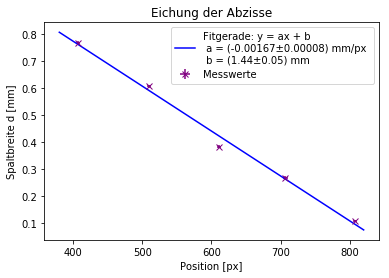

In [5]:
plt.errorbar(unumpy.nominal_values(pos_abz), unumpy.nominal_values(d_abz), \
            xerr=unumpy.std_devs(pos_abz), yerr=unumpy.std_devs(d_abz), \
            ls='None', color='purple', marker='x', label='Messwerte')

x=np.linspace(380,820)
plt.plot(x, linear(x, *popt_abz), color='blue', \
         label='Fitgerade: y = ax + b \n a = ({:P}) mm/px \n b = ({:P}) mm'.format(a_abz, b_abz))

plt.legend()
plt.title('Eichung der Abzisse')
plt.xlabel('Position [px]')
_ = plt.ylabel('Spaltbreite d [mm]')
plt.savefig('Abzisseneichung.pdf', format='pdf')

In [6]:
e = -a_abz
print('Umrechnugsfaktor: e_abz = {:P} mm/px'.format(e))

Umrechnugsfaktor: e_abz = 0.00167±0.00008 mm/px


---

## Aufgabe 2

Parameter:

In [7]:
lambda_las = 532 * 10 **(-6) #[mm]
f_lit = 80 #[mm]

Positionen der Nebenmaxima und -minima:

In [8]:
pos_min_links = unumpy.uarray([687, 612, 539, 462, 389], 3) #[px]
pos_min_rechts = unumpy.uarray([834, 907, 980, 1055, 1129], 3) #[px]

pos_max_links = unumpy.uarray([655, 577, 502, 426, 356], 3) #[px]
pos_max_rechts = unumpy.uarray([866, 941, 1017, 1091, 1167], 3) #[px]

n = np.arange(1,6)
n_max = np.arange(1.5, 6.5)

Geradenfits:

In [9]:
popt_links, pcov_links = curve_fit(linear, n, unumpy.nominal_values(pos_min_links), \
                                   sigma =unumpy.std_devs(pos_min_links))

a_links = ufloat(popt_links[0], np.sqrt(pcov_links[0][0]))
b_links = ufloat(popt_links[1], np.sqrt(pcov_links[1][1]))

popt_rechts, pcov_rechts = curve_fit(linear, n, unumpy.nominal_values(pos_min_rechts), \
                                     sigma =unumpy.std_devs(pos_min_rechts))

a_rechts = ufloat(popt_rechts[0], np.sqrt(pcov_rechts[0][0]))
b_rechts = ufloat(popt_rechts[1], np.sqrt(pcov_rechts[1][1]))

n_plot = np.linspace(0.75, 5.75)

In [10]:
def lin_max_links(y):
    return (y-b_links)/a_links

def lin_max_rechts(y):
    return (y-b_rechts)/a_rechts

### "Ordnungszahlen" Maxima:

In [11]:
ord_max_links = lin_max_links(pos_max_links)
ord_max_rechts = lin_max_rechts(pos_max_rechts)

In [12]:
def max_sinc(n):
    return (n + 0.5) * np.pi - 1/((n + 0.5) * np.pi)

max_pos_lit = max_sinc(np.arange(1,6))

ord_max_lit = max_pos_lit/np.pi

Signifikanztest:

In [13]:
sigma_ord_links = abs(unumpy.nominal_values(ord_max_links)- unumpy.nominal_values(ord_max_lit)) \
                    /np.sqrt(unumpy.std_devs(ord_max_links)**2 + unumpy.std_devs(ord_max_lit))

sigma_ord_rechts = abs(unumpy.nominal_values(ord_max_rechts)- unumpy.nominal_values(ord_max_lit)) \
                    /np.sqrt(unumpy.std_devs(ord_max_rechts)**2 + unumpy.std_devs(ord_max_lit))

Tabelle:

In [14]:
table_ord = np.array([np.arange(1,6), ord_max_lit, ord_max_links, sigma_ord_links, ord_max_rechts, sigma_ord_rechts]).T

print(tabulate(table_ord, tablefmt='latex', \
               headers=['Ordnung', 'n_lit', 'n_links', 'sigma_links', 'n_rechts', 'sigma_rechts']))

\begin{tabular}{rrlrlr}
\hline
   Ordnung &   n\_lit & n\_links     &   sigma\_links & n\_rechts    &   sigma\_rechts \\
\hline
         1 & 1.43245 & 1.43+/-0.04 &     0.0809547 & 1.44+/-0.04 &      0.219969  \\
         2 & 2.45947 & 2.47+/-0.04 &     0.341429  & 2.46+/-0.04 &      0.0346265 \\
         3 & 3.47105 & 3.48+/-0.05 &     0.194798  & 3.49+/-0.04 &      0.38647   \\
         4 & 4.47748 & 4.50+/-0.05 &     0.449833  & 4.49+/-0.04 &      0.294512  \\
         5 & 5.48158 & 5.44+/-0.05 &     0.911018  & 5.52+/-0.05 &      0.853997  \\
\hline
\end{tabular}


---

### Plots

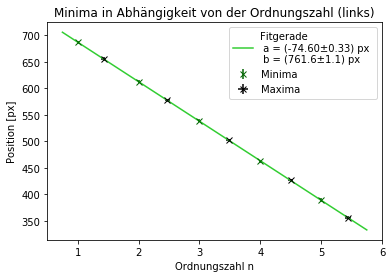

In [15]:
plt.errorbar(n, unumpy.nominal_values(pos_min_links), yerr=unumpy.std_devs(pos_min_links), \
             ls='None', marker='x', color='darkgreen', label='Minima')
plt.plot(n_plot, linear(n_plot, *popt_links), \
         label='Fitgerade \n a = ({:P}) px \n b = ({:P}) px'.format(a_links, b_links), color='limegreen')
plt.errorbar(unumpy.nominal_values(ord_max_links), unumpy.nominal_values(pos_max_links), \
             xerr=unumpy.std_devs(ord_max_links), yerr=unumpy.std_devs(pos_max_links), \
             ls='None', marker='x', color='black', label='Maxima')
plt.legend()

plt.title('Minima in Abhängigkeit von der Ordnungszahl (links)')
plt.xlabel('Ordnungszahl n')
plt.ylabel('Position [px]')
plt.savefig('Minima_links.pdf', format='pdf')

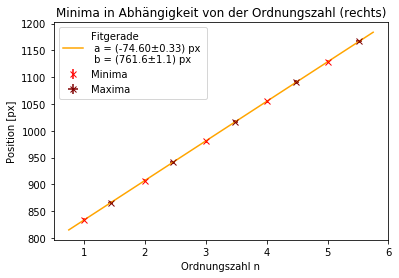

In [16]:
plt.errorbar(n, unumpy.nominal_values(pos_min_rechts), yerr=unumpy.std_devs(pos_min_rechts), \
             ls='None', marker='x', color='red', label='Minima')
plt.plot(n_plot, linear(n_plot, *popt_rechts), \
         label='Fitgerade \n a = ({:P}) px \n b = ({:P}) px'.format(a_links, b_links), \
         color='orange')
plt.errorbar(unumpy.nominal_values(ord_max_rechts), unumpy.nominal_values(pos_max_rechts), \
             xerr=unumpy.std_devs(ord_max_rechts), yerr=unumpy.std_devs(pos_max_rechts), \
             ls='None', marker='x', color='maroon', label='Maxima')
plt.legend()

plt.title('Minima in Abhängigkeit von der Ordnungszahl (rechts)')
plt.xlabel('Ordnungszahl n')
plt.ylabel('Position [px]')
plt.savefig('Minima_rechts.pdf', format='pdf')

---

### Spaltbreite

In [17]:
d_1 = (f_lit * lambda_las)/(-a_links*e)

d_2 = (f_lit * lambda_las)/(a_rechts*e)

In [18]:
print('d_1 = ({:P}) mm \nd_2 = ({:P}) mm'.format(d_1, d_2))

d_1 = (0.342±0.017) mm 
d_2 = (0.346±0.017) mm


Signifikanztest:

In [19]:
sigma_d_einzel = abs(d_1.n - d_2.n)/np.sqrt(d_1.s**2 + d_2.s**2)
print('sigma_d_einzel = {:.2f}'.format(sigma_d_einzel))

sigma_d_einzel = 0.15


---

### Intensitätsverhältnisse:

Messwerte:

In [20]:
I_0 = ufloat(749, 5)

I_max1_links = ufloat(32, 2)

I_max1_rechts = ufloat(31, 2)

I_max_links = unumpy.uarray([959, 349, 179, 114, 78], [20, 10, 5, 5, 2])

I_max_rechts = unumpy.uarray([939, 324, 169, 97, 75], [20, 10, 5, 5, 2])

Skaliere I$_0$:

In [21]:
I_0_links = I_0 * I_max_links[0]/I_max1_links

I_0_rechts = I_0 * I_max_rechts[0]/I_max1_rechts

In [22]:
I_ver_links = I_max_links/I_0_links

I_ver_rechts = I_max_rechts/I_0_rechts

I_ver_theo = (np.sin(max_pos_lit)/max_pos_lit)**2

In [23]:
sigma_ver_links = abs(unumpy.nominal_values(I_ver_links)-I_ver_theo) \
                    /unumpy.std_devs(I_ver_links)

sigma_ver_rechts = abs(unumpy.nominal_values(I_ver_rechts)-I_ver_theo) \
                    /unumpy.std_devs(I_ver_rechts)

Erstelle Tabelle:

In [24]:
table_ver = np.array([np.arange(1,6), I_ver_theo, I_ver_links, sigma_ver_links, I_ver_rechts, sigma_ver_rechts]).T

print(tabulate(table_ver, tablefmt='latex', \
               headers=['Ordnung', '(I/I_0)_theo', '(I/I_0)_links', 'sigma_links', '(I/I_0)_rechts', 'sigma_rechts']))

\begin{tabular}{rrlrlr}
\hline
   Ordnung &   (I/I\_0)\_theo & (I/I\_0)\_links     &   sigma\_links & (I/I\_0)\_rechts    &   sigma\_rechts \\
\hline
         1 &     0.0471883  & 0.0427+/-0.0027   &      1.66256  & 0.0414+/-0.0027   &       2.16048  \\
         2 &     0.01648    & 0.0155+/-0.0011   &      0.830705 & 0.0143+/-0.0011   &       2.05521  \\
         3 &     0.00834029 & 0.0080+/-0.0006   &      0.638222 & 0.0074+/-0.0006   &       1.60805  \\
         4 &     0.00502872 & 0.0051+/-0.0004   &      0.12395  & 0.0043+/-0.0004   &       2.05947  \\
         5 &     0.00336073 & 0.00347+/-0.00025 &      0.462713 & 0.00331+/-0.00024 &       0.226746 \\
\hline
\end{tabular}


---
---

## Aufgabe 3

Messwerte der Spaltbreite beim Doppelspalt:

In [25]:
m1_links = ufloat(57, 5) #[px]
m1_rechts = ufloat(289, 5)

m1 = m1_rechts - m1_links #linke Spaltbreite

m2_links = ufloat(615, 5)
m2_rechts = ufloat(920, 5)

m2 = m2_rechts - m2_links #rechte Spaltbreite

m_doppel = (m2+m1)/2

abs_links = ufloat(173, 5)
abs_rechts = ufloat(766, 5)
a_g = abs_rechts-abs_links

v_exp = (2*a_g)/(m1+m2)
print(v_exp)

2.21+/-0.05


Theoretisch erwartete Beugungsbilder:

In [26]:
#Beugungsfunktion Spalt
def beugung_spalt(x):
    return np.sinc(x)**2

#Beugungsfunktion Doppelspalt
def beugung_doppelspalt(x):
    return np.sinc(x)**2*np.cos(np.pi*v*x)**2

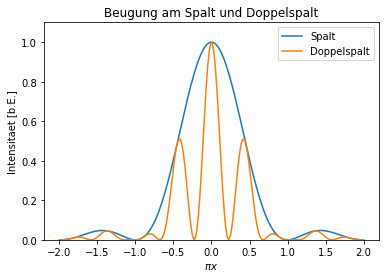

In [27]:
#Anzahl a der Nebenmaxima die dargestellt werden sollen:
a=1
#Verhaeltnis Spaltabstand zu Spaltbreite:
v=v_exp.n
x=np.linspace(-(a+1),a+1,200)
plt.plot(x,beugung_spalt(x),label='Spalt')
plt.plot(x,beugung_doppelspalt(x),label='Doppelspalt')

plt.xlabel('$\pi x$')
plt.ylabel('Intensitaet [b.E.]')
plt.title('Beugung am Spalt und Doppelspalt')
plt.ylim((0,1.1))
plt.legend()
plt.savefig("Beugung_spalt_doppelspalt.pdf", format="pdf")

In [28]:
pix, inten=np.loadtxt('Aufgabe3/Aufgabe3doppelspalt.txt', skiprows=3, delimiter=';', \
                      unpack=True, usecols=range(2))

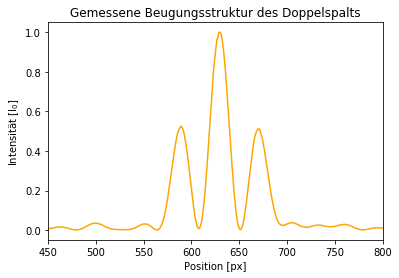

In [29]:
plt.plot(pix, inten/881, color='orange')

plt.title('Gemessene Beugungsstruktur des Doppelspalts')
plt.xlabel('Position [px]')
plt.ylabel(r'Intensität [I$_0$]')
plt.xlim(450,800)
plt.savefig('Beugung_doppelspalt.pdf', format='pdf')

### Internsitätsverhältnisse

Messwerte:

In [30]:
I_d0 = ufloat(882, 5)

I_dmax_links = unumpy.uarray([462, 27], [5, 2])
I_dmax_rechts = unumpy.uarray([449, 35], [5, 2])

I_dver_links = I_dmax_links/I_d0
I_dver_rechts = I_dmax_rechts/I_d0

I_dver_links, I_dver_rechts

(array([0.5238095238095238+/-0.006399562461467281,
        0.030612244897959183+/-0.002274204516680915], dtype=object),
 array([0.5090702947845805+/-0.0063612226474174345,
        0.03968253968253968+/-0.002278704991396602], dtype=object))

Theoretisch erwartete Werte:

In [31]:
x=np.linspace(0,1,200)
peakind = signal.find_peaks_cwt(beugung_doppelspalt(x), np.arange(0.1,2), noise_perc=0)
#plt.plot(x[peakind], beugung_doppelspalt(x)[peakind],marker='o', linewidth=0)
#plt.plot(x,beugung_doppelspalt(x))
#print(x[peakind])

I_dver_theo = [0,0]

I_dver_theo[0] = np.sinc(x[peakind][0])**2*umath.cos(np.pi*v_exp*x[peakind][0])**2
I_dver_theo[1] = np.sinc(x[peakind][1])**2*umath.cos(np.pi*v_exp*x[peakind][1])**2

print(I_dver_theo)

[0.511399810287859+/-0.014313428150307504, 0.030345494584297576+/-0.006364545908546894]


Signifikanztest:

In [32]:
sigma_dver_links = abs(unumpy.nominal_values(I_dver_theo)-unumpy.nominal_values(I_dver_links)) \
                        /np.sqrt(unumpy.std_devs(I_dver_theo)**2 +unumpy.std_devs(I_dver_links)**2)
sigma_dver_rechts = abs(unumpy.nominal_values(I_dver_theo)-unumpy.nominal_values(I_dver_rechts)) \
                        /np.sqrt(unumpy.std_devs(I_dver_theo)**2 +unumpy.std_devs(I_dver_rechts)**2)

In [33]:
table_dver = np.array([np.arange(1,3), I_dver_theo, I_dver_links, sigma_dver_links, \
                       I_dver_rechts, sigma_dver_rechts]).T

print(tabulate(table_dver, tablefmt='latex', \
               headers=['Ordnung', '(I/I_0)_theo', '(I/I_0)_links', 'sigma_links', \
                        '(I/I_0)_rechts', 'sigma_rechts']))

\begin{tabular}{rllrlr}
\hline
   Ordnung & (I/I\_0)\_theo   & (I/I\_0)\_links   &   sigma\_links & (I/I\_0)\_rechts   &   sigma\_rechts \\
\hline
         1 & 0.511+/-0.014  & 0.524+/-0.006   &     0.79149   & 0.509+/-0.006    &       0.148724 \\
         2 & 0.030+/-0.006  & 0.0306+/-0.0023 &     0.0394679 & 0.0397+/-0.0023  &       1.38118  \\
\hline
\end{tabular}


---

## Aufgabe 4

In [34]:
d_links = ufloat(261, 5) #[px]
d_rechts = ufloat(452, 5) #[px]

d_spalt = d_rechts - d_links

d=d_spalt.n #Spaltbreite auf 1 setzen
n=1 #Integrationsbereich

#y-Werte:
Y=np.linspace(-1,1,200)*d

In [35]:
def bildspalt(n): #Bilder als Funktionen Definieren
    #Integrand
    def spalt(k,y):
        return d/np.pi*np.sin(k*d/2)/(k*d/2)*np.cos(y*k)
    
    #y-Werte:
    Y=np.linspace(-1,1,200)*d
    
    #Berechnung des resultierenden Objektbilds
    f_modifiziert=[]
    for i in range(len(Y)):
        y=Y[i]
        result, error = quad(spalt, 0, 2*np.pi*n/d, args =(y,))
        f_modifiziert.append(result**2)
    
    f_max = np.max(f_modifiziert)
    
    #Kurve auf 1 normieren:
    f_modifiziert = f_modifiziert/np.max(f_modifiziert)
    plt.xlabel('Position [px]')
    plt.ylabel('Intensitaet [b.E.]')
    plt.title('modifiziertes Objektbild Spalt (bis Ordnung {})'.format(n-1))
    plt.ylim((0,1.1))
    plt.grid(True)
    
    #Extrema finden:
    if n<6:
        peaksmax, _ = find_peaks(+f_modifiziert, distance=10, height=[0.5,1])
        peaksmin, _ = find_peaks(-f_modifiziert, distance=10, height=[-1,-0.5])
        print('(Mögliche) Positionen Maxima:', peaksmax*2-200, \
              '\n(Mögliche) Intensitäten Maxima:', f_modifiziert[peaksmax], \
              '\n(Mögliche) normierte Intensitäten Maxima:', f_modifiziert[peaksmax]*f_max)
        print('(Mögliche) Positionen Minima:', peaksmin*2-200, \
              '\n(Mögliche) Intensitäten Minima:', f_modifiziert[peaksmin], \
              '\n(Mögliche) normierte Intensitäten Minima:', f_modifiziert[peaksmin]*f_max)
    
    plt.plot(Y,f_modifiziert)
    plt.savefig('Theoretische Spaltbilder/Spalt_theo_{}.pdf'.format(n-1), format='pdf')

Werte einlesen:

In [36]:
def spalt_mess(s, n, m, r):
    pix, inten = np.loadtxt(s, skiprows=3, delimiter=';', \
                      unpack=True, usecols=range(2))
    
    if n==3:
        inten = inten-156
    
    #Kurve auf 1 normieren:
    inten_modifiziert = inten/np.max(inten)
    plt.xlabel('Position [px]')
    plt.ylabel('Intensitaet [b.E.]')
    plt.title('gemessenes und normiertes Objektbild Spalt (bis Ordnung {})'.format(n))
    plt.ylim((0,1.1))
    plt.xlim((-205,205))
    plt.grid(True)
    
    #Extrema finden:
    #if n<6:
    peaksmax, _ = find_peaks(+inten_modifiziert, distance=m, height=[0.5,1])
    peaksmin, _ = find_peaks(-inten_modifiziert, distance=m, height=[-1,-0.6])
    print('(Mögliche) Positionen Maxima:', peaksmax-r, \
          '\n(Mögliche) Intensitäten Maxima:', inten_modifiziert[peaksmax])
    print('(Mögliche) Positionen Minima:', peaksmin-r, \
          '\n(Mögliche) Intensitäten Minima:', inten_modifiziert[peaksmin])
    
    plt.plot(pix-r,inten_modifiziert, color='orange')
    plt.savefig('Gemessene Spaltbilder/spalt_{}_norm.pdf'.format(n), format='pdf')

#Verschiebungswerte:
#387
#504
#343
#310
#355.5

In [37]:
def spalt_mess2(s, n, m, r):
    pix, inten = np.loadtxt(s, skiprows=3, delimiter=';', \
                      unpack=True, usecols=range(2))
    
    if n==3:
        inten = inten-156
    
    #Kurve auf 1 normieren:
    inten_modifiziert = inten
    plt.xlabel('Position [px]')
    plt.ylabel('Intensitaet [b.E.]')
    plt.title('gemessenes Objektbild Spalt (bis Ordnung {})'.format(n))
    plt.ylim((0,1.1*np.max(inten)))
    #plt.xlim((-205,205))
    plt.grid(True)
    
    #Extrema finden:
    #if n<6:
    peaksmax, _ = find_peaks(+inten_modifiziert, distance=m, height=[0.5*np.max(inten),1*np.max(inten)])
    peaksmin, _ = find_peaks(-inten_modifiziert, distance=m, height=[-1*np.max(inten),-0.6*np.max(inten)])
    print('(Mögliche) Positionen Maxima:', peaksmax, \
          '\n(Mögliche) normierte Intensitäten Maxima:', inten_modifiziert[peaksmax])
    print('(Mögliche) Positionen Minima:', peaksmin, \
          '\n(Mögliche) normierte Intensitäten Minima:', inten_modifiziert[peaksmin])
    
    plt.plot(pix,inten_modifiziert, color='red')
    plt.savefig('Gemessene Spaltbilder/spalt_{}.pdf'.format(n), format='pdf')

#Verschiebungswerte:
#387
#504
#343
#310
#355.5

(Mögliche) Positionen Maxima: [-2] 
(Mögliche) Intensitäten Maxima: [1.] 
(Mögliche) normierte Intensitäten Maxima: [1.38975508]
(Mögliche) Positionen Minima: [] 
(Mögliche) Intensitäten Minima: [] 
(Mögliche) normierte Intensitäten Minima: []


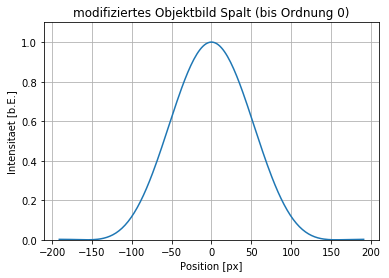

In [38]:
bildspalt(1)

(Mögliche) Positionen Maxima: [0] 
(Mögliche) Intensitäten Maxima: [1.]
(Mögliche) Positionen Minima: [-37  25] 
(Mögliche) Intensitäten Minima: [0.76143884 0.92471772]


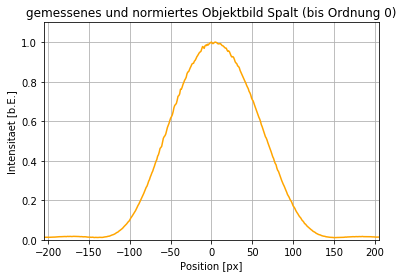

In [39]:
spalt_mess('Aufgabe4/A4_1Spalt_0Ord.txt', 0, 50, 387)

(Mögliche) Positionen Maxima: [387] 
(Mögliche) normierte Intensitäten Maxima: [632.36338]
(Mögliche) Positionen Minima: [350 412] 
(Mögliche) normierte Intensitäten Minima: [481.50604 584.75762]


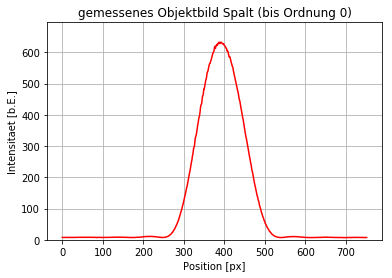

In [40]:
spalt_mess2('Aufgabe4/A4_1Spalt_0Ord.txt', 0, 50, 387)

(Mögliche) Positionen Maxima: [-50  48] 
(Mögliche) Intensitäten Maxima: [1. 1.] 
(Mögliche) normierte Intensitäten Maxima: [1.25985501 1.25985501]
(Mögliche) Positionen Minima: [-2] 
(Mögliche) Intensitäten Minima: [0.64726074] 
(Mögliche) normierte Intensitäten Minima: [0.81545468]


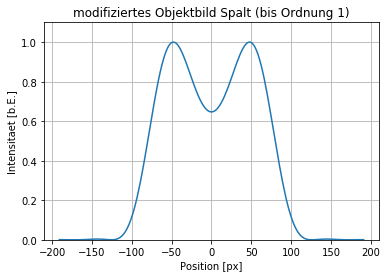

In [41]:
bildspalt(2)

(Mögliche) Positionen Maxima: [-48   2  45] 
(Mögliche) Intensitäten Maxima: [1.         0.62798873 0.99415018]
(Mögliche) Positionen Minima: [-52   0  42] 
(Mögliche) Intensitäten Minima: [0.98950242 0.62297277 0.97584856]


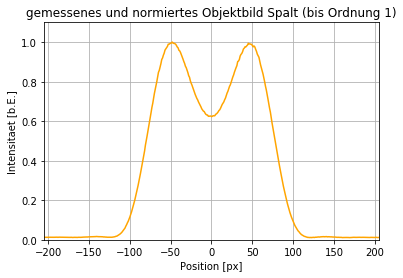

In [42]:
spalt_mess('Aufgabe4/A4_1Spalt_1Ord.txt', 1, 40, 504)

(Mögliche) Positionen Maxima: [456 506 549] 
(Mögliche) normierte Intensitäten Maxima: [582.17201 365.59746 578.76641]
(Mögliche) Positionen Minima: [452 504 546] 
(Mögliche) normierte Intensitäten Minima: [576.06061 362.67731 568.11172]


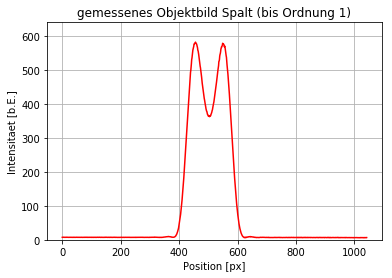

In [43]:
spalt_mess2('Aufgabe4/A4_1Spalt_1Ord.txt', 1, 40, 504)

(Mögliche) Positionen Maxima: [-68  -2  66] 
(Mögliche) Intensitäten Maxima: [1.         0.92316817 1.        ] 
(Mögliche) normierte Intensitäten Maxima: [1.23066199 1.13610798 1.23066199]
(Mögliche) Positionen Minima: [-34  32] 
(Mögliche) Intensitäten Minima: [0.69734819 0.69734819] 
(Mögliche) normierte Intensitäten Minima: [0.85819991 0.85819991]


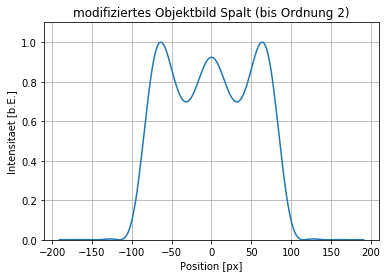

In [44]:
bildspalt(3)

(Mögliche) Positionen Maxima: [-59   0  63] 
(Mögliche) Intensitäten Maxima: [1.         0.9644307  0.97702035]
(Mögliche) Positionen Minima: [-34  34] 
(Mögliche) Intensitäten Minima: [0.72556815 0.73213901]


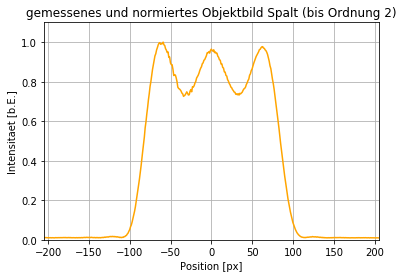

In [45]:
spalt_mess('Aufgabe4/A4_1Spalt_2Ord.txt',2,35, 343)

(Mögliche) Positionen Maxima: [284 343 406] 
(Mögliche) normierte Intensitäten Maxima: [625.42335 603.17748 611.05134]
(Mögliche) Positionen Minima: [309 377] 
(Mögliche) normierte Intensitäten Minima: [453.78726 457.89683]


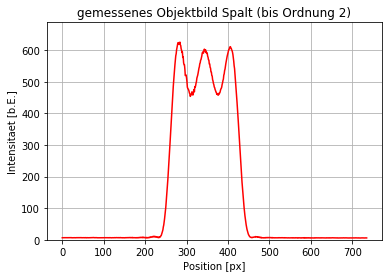

In [46]:
spalt_mess2('Aufgabe4/A4_1Spalt_2Ord.txt',2,35, 343)

(Mögliche) Positionen Maxima: [-76 -26  24  74] 
(Mögliche) Intensitäten Maxima: [1.         0.91044864 0.91044864 1.        ] 
(Mögliche) normierte Intensitäten Maxima: [1.21831902 1.1092169  1.1092169  1.21831902]
(Mögliche) Positionen Minima: [-50  -2  48] 
(Mögliche) Intensitäten Minima: [0.71744022 0.74130956 0.71744022] 
(Mögliche) normierte Intensitäten Minima: [0.87407107 0.90315154 0.87407107]


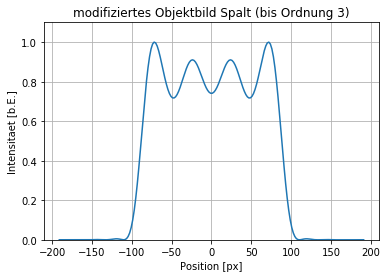

In [47]:
bildspalt(4)

(Mögliche) Positionen Maxima: [-69 -26  19  66] 
(Mögliche) Intensitäten Maxima: [1.         0.91839392 0.90450627 0.95787691]
(Mögliche) Positionen Minima: [-48   0  42] 
(Mögliche) Intensitäten Minima: [0.74268322 0.7785534  0.75218845]


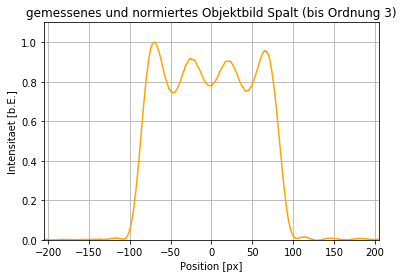

In [48]:
spalt_mess('Aufgabe4/A4_1Spalt_3Ord.txt', 3, 30, 310)

(Mögliche) Positionen Maxima: [241 284 329 376] 
(Mögliche) normierte Intensitäten Maxima: [768.69661 705.96629 695.2909  736.31673]
(Mögliche) Positionen Minima: [262 310 352] 
(Mögliche) normierte Intensitäten Minima: [570.89807 598.47136 578.20471]


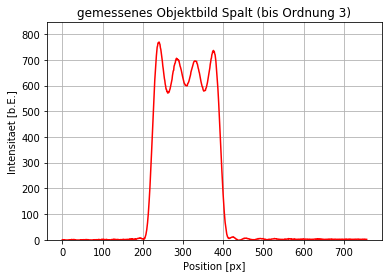

In [49]:
spalt_mess2('Aufgabe4/A4_1Spalt_3Ord.txt', 3, 30, 310)

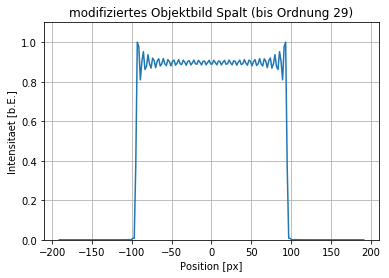

In [50]:
bildspalt(30)

(Mögliche) Positionen Maxima: [-282.5] 
(Mögliche) Intensitäten Maxima: [1.]
(Mögliche) Positionen Minima: [-124.5] 
(Mögliche) Intensitäten Minima: [0.64110196]


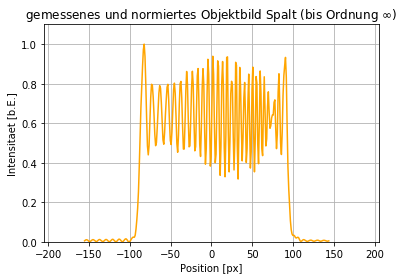

In [51]:
spalt_mess('Aufgabe4/A4_1Spalt_alle_txt.txt', r'$\infty$', 500, 355.5)

(Mögliche) Positionen Maxima: [73] 
(Mögliche) normierte Intensitäten Maxima: [739.30496]
(Mögliche) Positionen Minima: [231] 
(Mögliche) normierte Intensitäten Minima: [473.96986]


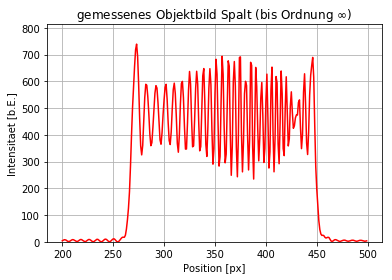

In [52]:
spalt_mess2('Aufgabe4/A4_1Spalt_alle_txt.txt', r'$\infty$', 500, 355.5)

---

### Intensitätsverhältnisse

Theoretisch erwartete Werte:

In [53]:
dtm = 0.05

int_0_tmax = ufloat(1.3898, dtm)

int_1_tmax = unumpy.uarray([1.2599, 1.2599], dtm)
int_1_tmin = ufloat(0.8155, dtm)

int_2_tmax = unumpy.uarray([1.2307, 1.1361, 1.2307], dtm)
int_2_tmin = unumpy.uarray([0.8582, 0.8582], dtm)

int_3_tmax = unumpy.uarray([1.2183, 1.1092, 1.1092, 1.2183], dtm)
int_3_tmin = unumpy.uarray([0.8741, 0.9032, 0.8741], dtm)

Gemessene Werte:

In [54]:
int_0_max = ufloat(632, 5)

int_1_max = unumpy.uarray([582, 579], 5)
int_1_min = ufloat(362, 5)

int_2_max = unumpy.uarray([625, 603, 611], 5)
int_2_min = unumpy.uarray([454, 458], 5)

int_3_max = unumpy.uarray([769, 706, 695, 736], 5)
int_3_min = unumpy.uarray([571, 598, 578], 5)

#### Berechne Verhältnisse:

Theoretisch:

In [55]:
ver_spalt1_tmax = int_1_tmax / int_0_tmax
ver_spalt1_tmin = int_1_tmin / int_0_tmax

ver_spalt2_tmax = int_2_tmax / int_0_tmax
ver_spalt2_tmin = int_2_tmin / int_0_tmax

ver_spalt3_tmax = int_3_tmax / int_0_tmax
ver_spalt3_tmin = int_3_tmin / int_0_tmax

Experimentell:

In [56]:
ver_spalt1_max = int_1_max / int_0_max
ver_spalt1_min = int_1_min / int_0_max

ver_spalt2_max = int_2_max / int_0_max
ver_spalt2_min = int_2_min / int_0_max

ver_spalt3_max = int_3_max / int_0_max
ver_spalt3_min = int_3_min / int_0_max

Signifikanztest:

In [57]:
def sigma_unum(x,y):
    return abs(unumpy.nominal_values(x)-unumpy.nominal_values(y)) \
              /np.sqrt(unumpy.std_devs(x)**2 + unumpy.std_devs(y)**2)

sigma_spalt1_max = sigma_unum(ver_spalt1_max, ver_spalt1_tmax)
sigma_spalt1_min = sigma_unum(ver_spalt1_min, ver_spalt1_tmin)

sigma_spalt2_max = sigma_unum(ver_spalt2_max, ver_spalt2_tmax)
sigma_spalt2_min = sigma_unum(ver_spalt2_min, ver_spalt2_tmin)

sigma_spalt3_max = sigma_unum(ver_spalt3_max, ver_spalt3_tmax)
sigma_spalt3_min = sigma_unum(ver_spalt3_min, ver_spalt3_tmin)

Erstelle Tabelle:

In [58]:
ver_tmax_list = np.concatenate([ver_spalt1_tmax, ver_spalt2_tmax, ver_spalt3_tmax], dtype='object')
ver_max_list = np.concatenate([ver_spalt1_max, ver_spalt2_max, ver_spalt3_max], dtype='object')
sigma_max_list = np.concatenate([sigma_spalt1_max, sigma_spalt2_max, sigma_spalt3_max], dtype='object')

ver_tmin_list = np.concatenate([np.array([ver_spalt1_tmin, 0]), ver_spalt2_tmin, np.array([0]), \
                                ver_spalt3_tmin, np.array([0]),], dtype='object')
ver_min_list = np.concatenate([np.array([ver_spalt1_min, 0]), ver_spalt2_min, np.array([0]), \
                               ver_spalt3_min, np.array([0])], dtype='object')
sigma_min_list = np.concatenate([np.array([sigma_spalt1_min, 0]), sigma_spalt2_min, np.array([0]), \
                                 sigma_spalt3_min, np.array([0])], dtype='object')

table_einzelspalt = np.array([np.array([1,1,2,2,2,3,3,3,3]), ver_tmax_list, ver_max_list, sigma_max_list, \
                                  ver_tmin_list, ver_min_list, sigma_min_list]).T

In [59]:
print(tabulate(table_einzelspalt, tablefmt='latex', \
               headers=['Ordnung', 'I_max,theo', 'I_max,exp', 'sigma_max', 'I_min,theo', 'I_min,exp', 'sigma_min']))

\begin{tabular}{rllrllr}
\hline
   Ordnung & I\_max,theo   & I\_max,exp     &   sigma\_max & I\_min,theo   & I\_min,exp     &   sigma\_min \\
\hline
         1 & 0.91+/-0.05  & 0.921+/-0.011 &    0.288581 & 0.59+/-0.04  & 0.573+/-0.009 &    0.327661 \\
         1 & 0.91+/-0.05  & 0.916+/-0.011 &    0.193161 & 0            & 0             &    0        \\
         2 & 0.89+/-0.05  & 0.989+/-0.011 &    2.09629  & 0.62+/-0.04  & 0.718+/-0.010 &    2.32438  \\
         2 & 0.82+/-0.05  & 0.954+/-0.011 &    2.86277  & 0.62+/-0.04  & 0.725+/-0.010 &    2.46987  \\
         2 & 0.89+/-0.05  & 0.967+/-0.011 &    1.64811  & 0            & 0             &    0        \\
         3 & 0.88+/-0.05  & 1.217+/-0.012 &    6.88073  & 0.63+/-0.04  & 0.903+/-0.011 &    6.26559  \\
         3 & 0.80+/-0.05  & 1.117+/-0.012 &    6.71083  & 0.65+/-0.04  & 0.946+/-0.011 &    6.69404  \\
         3 & 0.80+/-0.05  & 1.100+/-0.012 &    6.34805  & 0.63+/-0.04  & 0.915+/-0.011 &    6.51622  \\
         3 & 0.88+/

---
---

## Aufgabe 5

In [60]:
def bilddoppelspalt(n,m):
    def doppelspalt(k,y):
        return m_doppel.n/np.pi*np.cos(k*a_g.n/2)*np.sin(k*m_doppel.n/2)/(k*m_doppel.n/2)*np.cos(y*k)
    
    #y-Werte:
    Y=np.linspace(-2,2,200)*m_doppel.n
    
    #Berechnung des resultierenden Objektbilds
    
    f_modifiziert2=[]
    for i in range(len(Y)):
        y=Y[i]
        result, error = quad(doppelspalt, 0, 2*np.pi*n/m_doppel.n, args =(y,))
        f_modifiziert2.append(result**2)
    
    f_max2 = np.max(f_modifiziert2)
    
    #Kurve auf 1 normieren:
    f_modifiziert2 = f_modifiziert2/np.max(f_modifiziert2)
    
    #Extrema finden:
    #if n<6:
    peaksmax, _ = find_peaks(+f_modifiziert2, distance=m, height=[0.5,1])
    peaksmin, _ = find_peaks(-f_modifiziert2, distance=m, height=[-1,-0.5])
    print('(Mögliche) Positionen Maxima:', 6*(peaksmax-100), \
          '\n(Mögliche) Intensitäten Maxima:', f_modifiziert2[peaksmax], \
          '\n(Mögliche) normierte Intensitäten Maxima:', f_modifiziert2[peaksmax]*f_max2)
    print('(Mögliche) Positionen Minima:', 6*(peaksmin-100), \
          '\n(Mögliche) Intensitäten Minima:', f_modifiziert2[peaksmin], \
          '\n(Mögliche) normierte Intensitäten Minima:', f_modifiziert2[peaksmin]*f_max2)
    
    plt.xlabel('Position [px]')
    plt.ylabel('Intensitaet [b.E.]')
    plt.title('modifiziertes Objektbild Spalt (bis Ordnung {})'.format(n-1))
    plt.ylim((0,1.1))
    plt.xlim((-605,605))
    plt.grid(True)
    
    plt.plot(Y,f_modifiziert2)
    plt.savefig('Gemessene Doppelspaltbilder/doppelspalt_{}_theo.pdf'.format(n-1), format='pdf')

In [61]:
def doppelspalt_mess(s, n, m, r):
    pix, inten = np.loadtxt(s, skiprows=3, delimiter=';', \
                      unpack=True, usecols=range(2))
    
    
    
    #Kurve auf 1 normieren:
    inten_modifiziert = inten/np.max(inten)
    plt.xlabel('Position [px]')
    plt.ylabel('Intensitaet [b.E.]')
    
    if n != -1 and n != 1.1:
        plt.title('gemessenes und normiertes Objektbild Doppelspalt (bis Ordnung {})'.format(n))
        plt.ylim((0,1.1))
        plt.xlim((-605,605))
    elif n == 1.1:
        plt.title('gemessenes und normiertes Objektbild Doppelspalt (Gaußprofile)')
        plt.ylim((0,1.1))
        plt.xlim((-605,605))
    else:
        inten_modifiziert = (inten-0.55)/np.max(inten-0.55) * 1.2
        plt.title('gemessenes und normiertes Objektbild (Plateau)')
        plt.ylim((0,1.1))
        plt.xlim((-800,800))
    
    plt.grid(True)
    
    #Extrema finden:
    #if n<6:
    peaksmax, _ = find_peaks(+inten_modifiziert, distance=m, height=[0.6,1])
    peaksmin, _ = find_peaks(-inten_modifiziert, distance=m, height=[-1,-0.6])
    peaksmitte, _ = find_peaks(-inten_modifiziert, distance=m, height=[-0.2, -0.1])
    print('(Mögliche) Positionen Maxima:', peaksmax-r, \
          '\n(Mögliche) Intensitäten Maxima:', inten_modifiziert[peaksmax])
    print('(Mögliche) Positionen Minima:', peaksmin-r, \
          '\n(Mögliche) Intensitäten Minima:', inten_modifiziert[peaksmin])
    print('(Mögliche) Positionen Mitte:', peaksmitte-r, \
          '\n(Mögliche) Intensitäten Mitte:', inten_modifiziert[peaksmitte])
    
    plt.plot(pix-r,inten_modifiziert, color='orange')
    plt.savefig('Gemessene Doppelspaltbilder/doppelspalt_{}_norm.pdf'.format(n), format='pdf')

In [62]:
def doppelspalt_mess2(s, n, m, r):
    pix, inten = np.loadtxt(s, skiprows=3, delimiter=';', \
                      unpack=True, usecols=range(2))
    
    #Kurve auf 1 normieren:
    inten_modifiziert = inten
    plt.xlabel('Position [px]')
    plt.ylabel('Intensitaet [b.E.]')
    
    if n != -1 and n!=1.1:
        plt.title('gemessenes Objektbild Doppelspalt (bis Ordnung {})'.format(n))
        plt.ylim((0,1.1*np.max(inten)))
        plt.xlim((-605,605))
    elif n == 1.1:
        plt.title('gemessenes Objektbild Doppelspalt (Gaußprofile)')
        plt.ylim((0,1.1*np.max(inten)))
        plt.xlim((-605,605))
    else:
        inten_modifiziert = inten_modifiziert - 0.55
        plt.title('gemessenes Objektbild (Plateau)')
        plt.ylim((0,1.1*np.max(inten)))
        plt.xlim((-800,800))
    
    plt.grid(True)
    
    #Extrema finden:
    #if n<6:
    peaksmax, _ = find_peaks(+inten_modifiziert, distance=m, height=[0.6*np.max(inten),1*np.max(inten)])
    peaksmin, _ = find_peaks(-inten_modifiziert, distance=m, height=[-1*np.max(inten),-0.6*np.max(inten)])
    peaksmitte, _ = find_peaks(-inten_modifiziert, distance=m, height=[-0.2*np.max(inten), -0.1*np.max(inten)])
    print('(Mögliche) Positionen Maxima:', peaksmax-r, \
          '\n(Mögliche) normierte Intensitäten Maxima:', inten_modifiziert[peaksmax])
    print('(Mögliche) Positionen Minima:', peaksmin-r, \
          '\n(Mögliche) normierte Intensitäten Minima:', inten_modifiziert[peaksmin])
    print('(Mögliche) Positionen Minima:', peaksmitte-r, \
          '\n(Mögliche) normierte Intensitäten Mitte:', inten_modifiziert[peaksmitte])
    
    plt.plot(pix-r,inten_modifiziert, color='red')
    plt.savefig('Gemessene Doppelspaltbilder/doppelspalt_{}.pdf'.format(n), format='pdf')

(Mögliche) Positionen Maxima: [-336  330] 
(Mögliche) Intensitäten Maxima: [1. 1.] 
(Mögliche) normierte Intensitäten Maxima: [0.3451486 0.3451486]
(Mögliche) Positionen Minima: [] 
(Mögliche) Intensitäten Minima: [] 
(Mögliche) normierte Intensitäten Minima: []


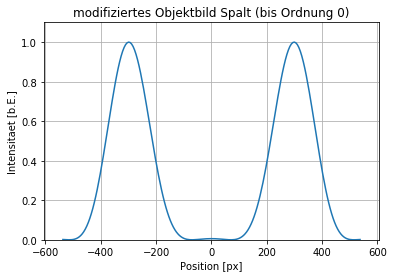

In [63]:
bilddoppelspalt(1, 10)

(Mögliche) Positionen Maxima: [-287  260] 
(Mögliche) Intensitäten Maxima: [0.96458024 1.        ]
(Mögliche) Positionen Minima: [-200  323] 
(Mögliche) Intensitäten Minima: [0.77695928 0.90348419]
(Mögliche) Positionen Mitte: [0] 
(Mögliche) Intensitäten Mitte: [0.10409958]


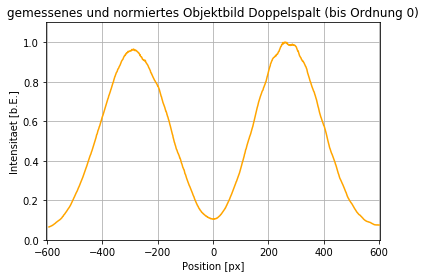

In [88]:
doppelspalt_mess('Aufgabe5/A5_2Spalt_0Ord.txt', 0, 400, 593)

(Mögliche) Positionen Maxima: [-287  260] 
(Mögliche) normierte Intensitäten Maxima: [267.59988 277.42625]
(Mögliche) Positionen Minima: [-200  323] 
(Mögliche) normierte Intensitäten Minima: [215.5489  250.65023]
(Mögliche) Positionen Minima: [0] 
(Mögliche) normierte Intensitäten Mitte: [28.879957]


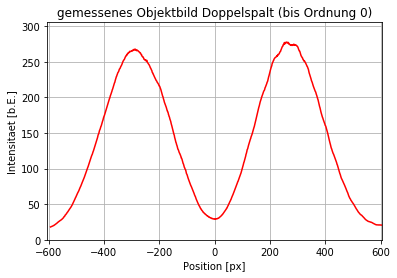

In [65]:
doppelspalt_mess2('Aufgabe5/A5_2Spalt_0Ord.txt', 0, 200, 593)

(Mögliche) Positionen Maxima: [-408 -258  252  402] 
(Mögliche) Intensitäten Maxima: [0.99621148 1.         1.         0.99621148] 
(Mögliche) normierte Intensitäten Maxima: [0.31708392 0.31828976 0.31828976 0.31708392]
(Mögliche) Positionen Minima: [-336  330] 
(Mögliche) Intensitäten Minima: [0.634803 0.634803] 
(Mögliche) normierte Intensitäten Minima: [0.2020513 0.2020513]


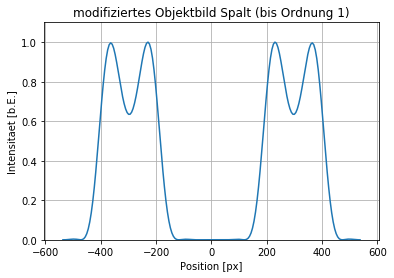

In [66]:
bilddoppelspalt(2,10)

(Mögliche) Positionen Maxima: [-347 -243  222  365] 
(Mögliche) Intensitäten Maxima: [0.90842817 0.94019283 1.         0.90947838]
(Mögliche) Positionen Minima: [-297  295] 
(Mögliche) Intensitäten Minima: [0.7621136  0.62230679]
(Mögliche) Positionen Mitte: [] 
(Mögliche) Intensitäten Mitte: []


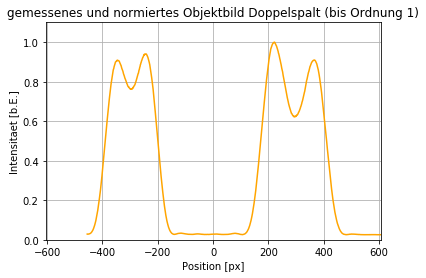

In [91]:
doppelspalt_mess('Aufgabe5/A5_2Spalt_1Ord.txt', 1, 100, 455)

(Mögliche) Positionen Maxima: [-347 -243  222  365] 
(Mögliche) normierte Intensitäten Maxima: [589.48299 610.09522 648.90435 590.16448]
(Mögliche) Positionen Minima: [-297  295] 
(Mögliche) normierte Intensitäten Minima: [494.53883 403.81758]
(Mögliche) Positionen Minima: [] 
(Mögliche) normierte Intensitäten Mitte: []


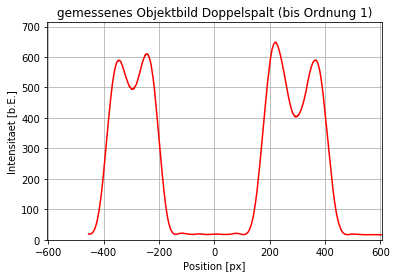

In [68]:
doppelspalt_mess2('Aufgabe5/A5_2Spalt_1Ord.txt', 1, 100, 455)

(Mögliche) Positionen Maxima: [-432 -330 -234  228  324  426] 
(Mögliche) Intensitäten Maxima: [0.99740132 0.92128233 1.         1.         0.92128233 0.99740132] 
(Mögliche) normierte Intensitäten Maxima: [0.30891396 0.28533847 0.30971882 0.30971882 0.28533847 0.30891396]
(Mögliche) Positionen Minima: [-384 -282  276  378] 
(Mögliche) Intensitäten Minima: [0.69022699 0.68788158 0.68788158 0.69022699] 
(Mögliche) normierte Intensitäten Minima: [0.21377629 0.21304987 0.21304987 0.21377629]


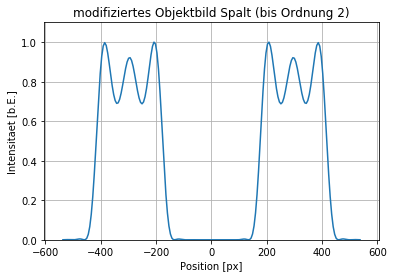

In [69]:
bilddoppelspalt(3,10)

(Mögliche) Positionen Maxima: [-356 -283 -210  209  291  401] 
(Mögliche) Intensitäten Maxima: [0.95376611 0.89323141 1.         0.882605   0.81756076 0.84571327]
(Mögliche) Positionen Minima: [-310 -249  248  358] 
(Mögliche) Intensitäten Minima: [0.81357055 0.78633649 0.70581519 0.71987409]
(Mögliche) Positionen Mitte: [] 
(Mögliche) Intensitäten Mitte: []


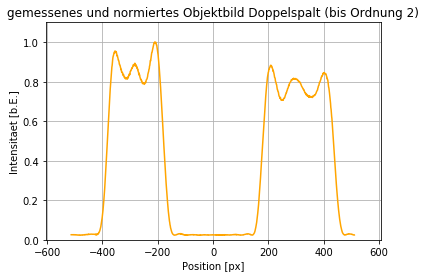

In [70]:
doppelspalt_mess('Aufgabe5/A5_2Spalt_2Ord.txt', 2, 60, 513)

(Mögliche) Positionen Maxima: [-356 -283 -210  209  291  401] 
(Mögliche) normierte Intensitäten Maxima: [639.39574 598.81385 670.3905  591.69001 548.08497 566.95814]
(Mögliche) Positionen Minima: [-310 -249  248  358] 
(Mögliche) normierte Intensitäten Minima: [545.40997 527.15251 473.1718  482.59675]
(Mögliche) Positionen Minima: [] 
(Mögliche) normierte Intensitäten Mitte: []


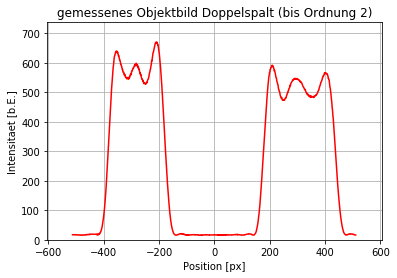

In [71]:
doppelspalt_mess2('Aufgabe5/A5_2Spalt_2Ord.txt', 2, 60, 513)

(Mögliche) Positionen Maxima: [-444 -372 -294 -222  216  288  366  438] 
(Mögliche) Intensitäten Maxima: [1.         0.90787751 0.90931704 0.99645077 0.99645077 0.90931704
 0.90787751 1.        ] 
(Mögliche) normierte Intensitäten Maxima: [0.30410702 0.27609192 0.27652969 0.30302767 0.30302767 0.27652969
 0.27609192 0.30410702]
(Mögliche) Positionen Minima: [-408 -330 -258  252  324  402] 
(Mögliche) Intensitäten Minima: [0.72007486 0.74491334 0.72062489 0.72062489 0.74491334 0.72007486] 
(Mögliche) normierte Intensitäten Minima: [0.21897982 0.22653337 0.21914709 0.21914709 0.22653337 0.21897982]


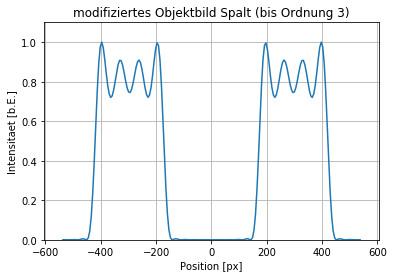

In [72]:
bilddoppelspalt(4,10)

(Mögliche) Positionen Maxima: [-365 -302 -251 -194  199  256  308  368  423] 
(Mögliche) Intensitäten Maxima: [1.         0.84325461 0.88719832 0.99742981 0.94179063 0.8247203
 0.70725415 0.70733835 0.76635049]
(Mögliche) Positionen Minima: [-332 -277 -222  231  283  338  394] 
(Mögliche) Intensitäten Minima: [0.68767245 0.75770026 0.72590651 0.72201373 0.71628015 0.66246657
 0.6233688 ]
(Mögliche) Positionen Mitte: [] 
(Mögliche) Intensitäten Mitte: []


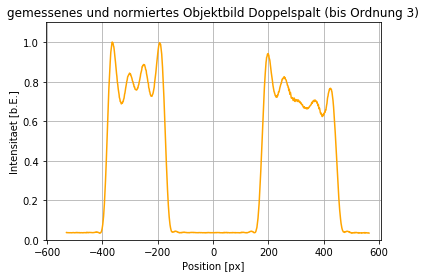

In [73]:
doppelspalt_mess('Aufgabe5/A5_2Spalt_3Ord.txt', 3, 50, 530)

(Mögliche) Positionen Maxima: [-365 -302 -251 -194  199  256  308  368  423] 
(Mögliche) normierte Intensitäten Maxima: [467.90678 394.56455 415.12611 466.70417 440.67022 385.89222 330.92901
 330.96841 358.58059]
(Mögliche) Positionen Minima: [-332 -277 -222  231  283  338  394] 
(Mögliche) normierte Intensitäten Minima: [321.7666  354.53309 339.65658 337.83512 335.15234 309.9726  291.67849]
(Mögliche) Positionen Minima: [] 
(Mögliche) normierte Intensitäten Mitte: []


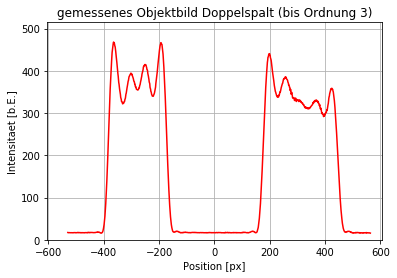

In [74]:
doppelspalt_mess2('Aufgabe5/A5_2Spalt_3Ord.txt', 3, 50, 530)

(Mögliche) Positionen Maxima: [468] 
(Mögliche) Intensitäten Maxima: [1.] 
(Mögliche) normierte Intensitäten Maxima: [0.29513817]
(Mögliche) Positionen Minima: [-198] 
(Mögliche) Intensitäten Minima: [0.76288697] 
(Mögliche) normierte Intensitäten Minima: [0.22515706]


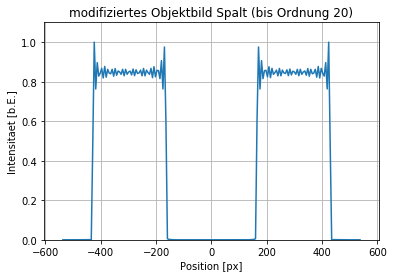

In [75]:
bilddoppelspalt(21,1000)

(Mögliche) Positionen Maxima: [-168] 
(Mögliche) Intensitäten Maxima: [1.]
(Mögliche) Positionen Minima: [191] 
(Mögliche) Intensitäten Minima: [0.60163731]
(Mögliche) Positionen Mitte: [] 
(Mögliche) Intensitäten Mitte: []


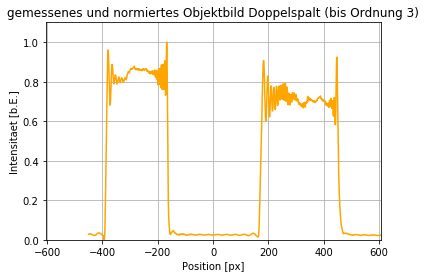

In [76]:
doppelspalt_mess('Aufgabe5/A5_2Spalt_alle.txt', 3, 1000, 450)

(Mögliche) Positionen Maxima: [-168] 
(Mögliche) normierte Intensitäten Maxima: [502.9469]
(Mögliche) Positionen Minima: [191] 
(Mögliche) normierte Intensitäten Minima: [302.59162]
(Mögliche) Positionen Minima: [] 
(Mögliche) normierte Intensitäten Mitte: []


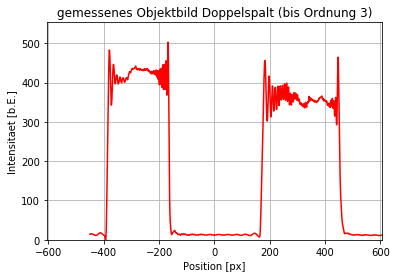

In [77]:
doppelspalt_mess2('Aufgabe5/A5_2Spalt_alle.txt', 3, 1000, 450)

---

Fall a:

(Mögliche) Positionen Maxima: [-299] 
(Mögliche) Intensitäten Maxima: [1.]
(Mögliche) Positionen Minima: [-340] 
(Mögliche) Intensitäten Minima: [0.7950183]
(Mögliche) Positionen Mitte: [-139] 
(Mögliche) Intensitäten Mitte: [0.13358358]


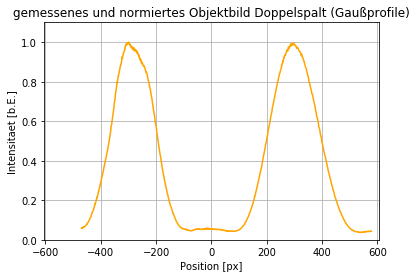

In [78]:
doppelspalt_mess('Aufgabe5/A5_2Spalt_analyse_1Ord.txt', 1.1, 1000, 470)

(Mögliche) Positionen Maxima: [-299] 
(Mögliche) normierte Intensitäten Maxima: [407.56546]
(Mögliche) Positionen Minima: [-340] 
(Mögliche) normierte Intensitäten Minima: [324.022]
(Mögliche) Positionen Minima: [-139] 
(Mögliche) normierte Intensitäten Mitte: [54.444054]


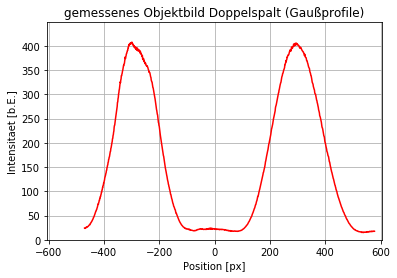

In [79]:
doppelspalt_mess2('Aufgabe5/A5_2Spalt_analyse_1Ord.txt', 1.1, 1000, 470)

Fall b:

(Mögliche) Positionen Maxima: [-78] 
(Mögliche) Intensitäten Maxima: [0.99884314]
(Mögliche) Positionen Minima: [314] 
(Mögliche) Intensitäten Minima: [0.60354504]
(Mögliche) Positionen Mitte: [-521  531] 
(Mögliche) Intensitäten Mitte: [0.10312299 0.10836366]
(Mögliche) Positionen Maxima: [-6] 
(Mögliche) Intensitäten Maxima: [1.] 
(Mögliche) normierte Intensitäten Maxima: [0.07082883]
(Mögliche) Positionen Minima: [] 
(Mögliche) Intensitäten Minima: [] 
(Mögliche) normierte Intensitäten Minima: []


Text(0.5, 1.0, 'gemessenes und normiertes Objektbild (Plateau mit n = 0.28)')

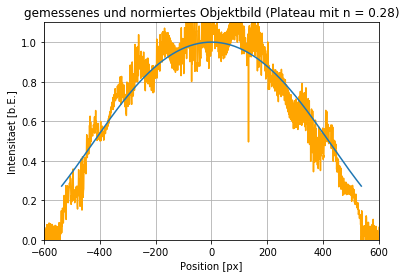

In [80]:
doppelspalt_mess('Aufgabe5/A5_2Spalt_analyse_verschmelzen_real.txt', -1, 1000, 615)
bilddoppelspalt(0.28,1000)
plt.xlim(-600,600)
plt.title('gemessenes und normiertes Objektbild (Plateau mit n = 0.28)')

(Mögliche) Positionen Maxima: [-78] 
(Mögliche) Intensitäten Maxima: [0.99884314]
(Mögliche) Positionen Minima: [314] 
(Mögliche) Intensitäten Minima: [0.60354504]
(Mögliche) Positionen Mitte: [-521  531] 
(Mögliche) Intensitäten Mitte: [0.10312299 0.10836366]


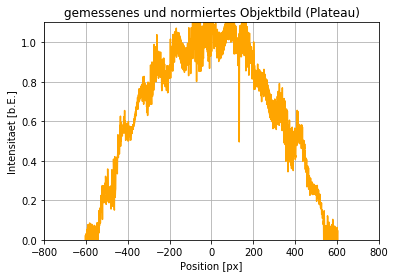

In [81]:
doppelspalt_mess('Aufgabe5/A5_2Spalt_analyse_verschmelzen_real.txt', -1, 1000, 615)

(Mögliche) Positionen Maxima: [] 
(Mögliche) normierte Intensitäten Maxima: []
(Mögliche) Positionen Minima: [] 
(Mögliche) normierte Intensitäten Minima: []
(Mögliche) Positionen Minima: [362] 
(Mögliche) normierte Intensitäten Mitte: [0.07584051]


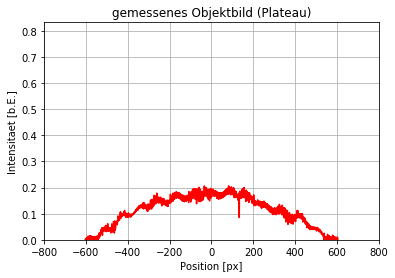

In [82]:
doppelspalt_mess2('Aufgabe5/A5_2Spalt_analyse_verschmelzen_real.txt', -1, 1000, 615)

---

Berechne k$_y$:

In [83]:
n_theo = ufloat(0.28, 0.02)

f_5 = ufloat(8.0, 0.5) * 10**(-2) #[m]
b_5 = ufloat(37.0, 0.5) * 10**(-2) #[m]

d_ana = ufloat(0.050, 0.005) * 10**(-3) #[m]

In [84]:
ky_exp = 2 * np.pi * d_ana / (lambda_las * 10**(-3) * f_5)
print(r'k_y,exp =', ky_exp, '1/m')

k_y,exp = (7.4+/-0.9)e+03 1/m


In [85]:
ky_theo = 2 * np.pi * n_theo / (m_doppel * 3.45*10**(-6) * f_5/(b_5-f_5))
print(r'k_y,theo =', ky_theo, '1/m')

k_y,theo = (6.9+/-0.8)e+03 1/m


In [86]:
sigma_ky = abs(ky_exp.n - ky_theo.n)/np.sqrt(ky_theo.s**2 + ky_exp.s**2)
print('sigma_ky =', round(sigma_ky,2))

sigma_ky = 0.43
